In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
require(phyloseq)

Loading required package: phyloseq


In [5]:
%%R
  require(reshape)
  require(picante)
  require(ape)
  require(gtools)

Loading required package: reshape
Loading required package: picante
Loading required package: ape
Loading required package: vegan
Loading required package: permute
Loading required package: lattice
This is vegan 2.3-0
Loading required package: nlme
Loading required package: gtools

Attaching package: ‘gtools’

The following object is masked from ‘package:permute’:

    permute



In [6]:
%%R
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom", "../../SeqData/trees/fulltree.tre", parseFunction = parse_taxonomy_greengenes)

In [92]:
%%R
ps = prune_samples(sample_data(physeq)$Month==2.5, physeq)
ps = prune_samples(sample_data(ps)$Trtmt=="F"|sample_data(ps)$Trtmt=="Q", ps)
#ps = prune_samples(sample_data(ps)$Trtmt=="F", ps)
ps = prune_samples(sample_data(ps)$Cosm==42, ps)
#ps = prune_samples(sample_data(ps)$Buff==1, ps)
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9190 taxa and 4 samples ]
sample_data() Sample Data:       [ 4 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 9190 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9190 tips and 9188 internal nodes ]


In [53]:
%%R
ps = subset_taxa(ps, Phylum=="Gemmatimonadetes")
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 211 taxa and 4 samples ]
sample_data() Sample Data:       [ 4 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 211 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 211 tips and 210 internal nodes ]


In [93]:
%%R
phy=phy_tree(ps)
samp=t(otu_table(ps))
# Need OTU table to have samples = rows

In [94]:
%%R
 samp <- t(samp)
# flips the OTU table back so now taxa are rows
  samp <- samp[mixedsort(rownames(samp)),]
# Gets the rownames
  sums <- subset(rowSums(samp), rowSums(samp) > 0)
# Cuts out any taxa with no representatives
  samp <- samp[names(sums),]
# Redefines the OTU table to it's only those samples

In [95]:
%%R
phy = prune.sample(t(samp), phy)
# Cuts out any not included taxa from the phylogenetic tree as well
phy


Phylogenetic tree with 3297 tips and 3295 internal nodes.

Tip labels:
	69_2370, 67.2_21506, 67_26460, 96_50315, 58_38953, 73_37380, ...
Node labels:
	, 0.826, 0.898, 0.938, 0.762, 0.921, ...

Unrooted; includes branch lengths.


In [96]:
%%R
samples = length(samp[1,])
taxa = length(samp[,1])
# gets the number of samples and OTUs we have

In [97]:
%%R
    phy$tip.label <- rep(1:length(phy$tip.label))
# Relabels the tree's OTUs to just numbers
    edge <- phy$edge[,2]
# Gets the beginning or ending node number for either tips or nodes..
  Bnode = taxa + 1
# We want one more node than we have taxa (maybe affected by whether tree is rooted or not?)
# I see at OTU 9191/9192 it jumps... not sure why...
  Li = t(t(dist.nodes(phy)[1:taxa, Bnode]))
# get the distance between all nodes from our tree
  Lb <- cbind(phy$edge[,2], phy$edge.length)
# Makes a table of the edge numbers and the edge lengths from our tree
  Lb <- Lb[order(Lb[,1]),] 
# Just orders that.

In [98]:
%%R 
p=matrix(0,taxa,samples)
#creates empty matrix of correct dimensions (taxa (rows) x  samples (cols))

In [99]:
%%R
p = t(apply(samp, 1, function(x) x/colSums(samp)))
# Populates the matrix with the relative abundance values for each OTU

In [100]:
%%R
That=matrix(0,1,samples)
That = t(as.matrix(apply(p,2,function(x) sum(Li*x))))

In [101]:
%%R


##########    This function returns the descendents of any internal node   #################################
  internal2tips.self = function (phy, int.node){
    #require(picante); require(ape)
    Ntaxa = length(phy$tip.label)
    Nnode = phy$Nnode
    if ((Ntaxa + Nnode - 1) != nrow(phy$edge)) {
      print("tree structure error")
      break
    }
    if (mode(int.node) == "character"){
      nodes = which(phy$node.label == int.node) + Ntaxa
    }
      else nodes = int.node
    tips = c()
    repeat {
      nodes = phy$edge[which(phy$edge[, 1] %in% nodes), 2]
      if (length(nodes) == 0)
        break
      tips = c(tips, nodes)
    }
    tips = tips[tips <= Ntaxa]
    if( int.node <= Ntaxa & length(tips) == 0 ){
      tips = int.node
    }
    tips = phy$tip.label[tips]
    return(tips)
  }
  

In [102]:
%%R

############################################################################################################
#####This builds the Z matrix from your phylogeny ######################################################
  ########################################################
  
S <- rep(1:length(phy$tip.label))
sp <- matrix(NA, nrow = length(S) + 1, ncol = length(edge) + 1)
sp[1,-1] <- sort(edge)
sp[-1,1] <- S
edges <- sp[1,]

### This is a little slow... 5:29 to 5:35 for 4 samples full spp.

In [103]:
%%R
Nedges = edges[2:ncol(sp)]
Nspecies = sp[2:nrow(sp)]
funcTips = function(x) {internal2tips.self(phy,x)}
funcList = lapply(Nedges,funcTips)
tmp = t(outer(funcList,Nspecies,function(x,y) mapply(function(x,y) ifelse(y %in% x,1,0),x,y)))
sp[2:nrow(sp),2:ncol(sp)]=tmp

In [37]:
%%R
#edges = edges[2:ncol(sp)]
#species = sp[2:nrow(sp),1]
#tmp = t(outer(edges,species,function(x,y)mapply(function(x,y) ifelse(y %in% internal2tips.self(phy,x),1,0),x,y)))
#sp[2:nrow(sp),2:ncol(sp)]=tmp

NULL


In [38]:
%%R
#hs <- sp[-1,-1]
#colnames(hs) <-sort(edge)
#rownames(hs) <- S
#hs <- melt(hs, varnames = c("species", "branch"))

#newmat = matrix(rep(p,each=nrow(hs)), nrow = nrow(hs), ncol=samples)
#hs = cbind(hs,newmat)

NULL


In [104]:
%%R
  hs <- sp[-1,-1]
  colnames(hs) <-sort(edge)
  rownames(hs) <- S
  hs <- melt(hs, varnames = c("species", "branch"))
  for (k in 1:samples){
    hs[,k + 3] <- rep(p[,k], length(edge))
  }

In [105]:
%%R

hs$Li <- rep(Li, length(edge))
hs <- hs[order(hs$species), ]
hs$Lb <- rep(Lb[,2], length(phy$tip.label))
hs <- (subset(hs, hs$value != 0))
hs <- hs[order(hs$species, hs$branch), ]

Z <- matrix(NA, nrow(hs), nrow(hs))
colnames(Z) <- hs$species
rownames(Z) <- hs$branch

### Below is the longest step - from 5:38 to .... for full spp 4 samples. Above takes ~4 min for same
Taking list out of the outer function sped it up.

In [ ]:
%%R

tmp = t(outer(Nedges,Nspecies,function(x,y) mapply(function(x,y) ifelse(y %in% x,1,0),x,y)))

Nbranch = hs$branch[1:length(hs$branch)]
Nspecies = hs$species[1:length(hs$species)]
funcTips = function(x) {internal2tips.self(phy,x)}
funcList = lapply(Nbranch,funcTips)
Z = outer(funcList, Nspecies, function(x,y)mapply(function(x,y) ifelse(y %in% x,That/Li[y],0),x,y))

In [88]:
%%R

pi <- matrix(0, ncol(Z), samples)
  for (k in 1:samples){
pi[,k] <- (hs$Lb/That[,k])*hs[,k+3]
}

In [89]:
%%R
 
  lenq <- 50
  qq <- seq(length = lenq, from  = 0, by = .11)
  
  # Initialise the Zp matrix to zero
  Zp=matrix(0,ncol(Z), samples)
  
  
  # Compute Zp
  for (k in 1:samples) {
    for (i in 1:ncol(Z)){
      for (j in 1:ncol(Z)){
        Zp[i,k]<-Zp[i,k]+Z[i,j]*pi[j,k]
      }
    }}


In [90]:
%%R
  
# Initialise the Diversity matrix to zero
Dqz = matrix(0, lenq ,samples)

#  Loop to calculate the diversity Dqz for each value of q (iq) and each sample (k)

for (k in 1:samples) {

for (iq in 1:lenq)  {
  q<-qq[iq];

  for (zpi in 1:length(Zp[,k])){
    if (Zp[zpi,k]>0)(
      Dqz[iq,k]<-Dqz[iq,k]+ pi[zpi,k]*(Zp[zpi,k])^(q-1))
  }

  Dqz[iq,k] <- Dqz[iq,k]^(1/(1-q));
}
}


### Stop here - original code

In [ ]:
%%R
#######################################################    DONE!!!! ##############################################
#Here's an example:

#data(phylocom)
#samp = phylocom$sample
#phy = prune.sample(samp, phylocom$phylo)

samp = OTUs
phy = Tree

the.answer <- Phylo.Z(phy = phy, samp = samp)

In [ ]:
%%R
#From https://gist.github.com/darmitage/2649763
############Here's a function that calculates Hill number diversity using a phylogeny from the Leinster and Cobbold (2012) paper

#Requires a phylogeny with tip labels and a community matrix (rows = samples, columns = species)
Phylo.Z <- function(phy,samp){

#packages required for this to work:
  require(reshape)
  require(picante)
  require(ape)
  require(gtools)
  
  phy <- prune.sample(samp,phy)
  samp <- t(samp)
  samp <- samp[mixedsort(rownames(samp)),]
  sums <- subset(rowSums(samp), rowSums(samp) > 0)
  samp <- samp[names(sums),]
  samples = length(samp[1,])
  taxa = length(samp[,1])
  phy$tip.label <- rep(1:length(phy$tip.label))
  edge <- phy$edge[,2]
    Bnode = taxa + 1
  Li = t(t(dist.nodes(phy)[1:taxa, Bnode]))
  Lb <- cbind(phy$edge[,2], phy$edge.length)
  Lb <- Lb[order(Lb[,1]),] 
  
  p=matrix(0,taxa,samples)
  
  for (k in 1:samples){
    p[,k]<-samp[,k]/sum(samp[,k])
  }
  
  That=matrix(0,1,samples)
  for (k in 1:samples){
    That[,k] <-sum(Li * p[,k])
  }

##########    This function returns the descendents of any internal node   #################################
  internal2tips.self = function (phy, int.node){
    #require(picante); require(ape)
    Ntaxa = length(phy$tip.label)
    Nnode = phy$Nnode
    if ((Ntaxa + Nnode - 1) != nrow(phy$edge)) {
      print("tree structure error")
      break
    }
    if (mode(int.node) == "character"){
      nodes = which(phy$node.label == int.node) + Ntaxa
    }else nodes = int.node
    tips = c()
    repeat {
      nodes = phy$edge[which(phy$edge[, 1] %in% nodes), 2]
      if (length(nodes) == 0)
        break
      tips = c(tips, nodes)
    }
    tips = tips[tips <= Ntaxa]
    if( int.node <= Ntaxa & length(tips) == 0 ){
      tips = int.node
    }
    tips = phy$tip.label[tips]
    return(tips)
  }
  
############################################################################################################
#####This builds the Z matrix from your phylogeny ######################################################
  ########################################################
  
  S <- rep(1:length(phy$tip.label))
  sp <- matrix(NA, nrow = length(S) + 1, ncol = length(edge) + 1)
  sp[1,-1] <- sort(edge)
  sp[-1,1] <- S
  edges <- sp[1,]
  
  for (i in (2:ncol(sp))) {
    branch <- internal2tips.self(phy,edges[i])
    
    for (j in (2:nrow(sp))){
      sp[j,i] <- ifelse(sp[j,1] %in% branch, 1, 0)
    }
  }
  
  hs <- sp[-1,-1]
  colnames(hs) <-sort(edge)
  rownames(hs) <- S
  hs <- melt(hs, varnames = c("species", "branch"))
  for (k in 1:samples){
    hs[,k + 3] <- rep(p[,k], length(edge))
  }

  hs$Li <- rep(Li, length(edge))
  hs <- hs[order(hs$species), ]
  hs$Lb <- rep(Lb[,2], length(phy$tip.label))
  hs <- (subset(hs, hs$value != 0))
  hs <- hs[order(hs$species, hs$branch), ]
  
  
  
  Z <- matrix(NA, nrow(hs), nrow(hs))
  colnames(Z) <- hs$species
  rownames(Z) <- hs$branch
  
  for(i in 1:length(hs$branch)){
    for(j in 1:length(hs$species)){
      branch <- internal2tips.self(phy,hs$branch[i])
      
      Z[i,j] <- ifelse(hs$species[j] %in% branch, That/Li[hs$species[j]], 0)
    }
  }

pi <- matrix(0, ncol(Z), samples)
  for (k in 1:samples){
pi[,k] <- (hs$Lb/That[,k])*hs[,k+3]
}
  
  lenq <- 50
  qq <- seq(length = lenq, from  = 0, by = .11)
  
  # Initialise the Zp matrix to zero
  Zp=matrix(0,ncol(Z), samples)
  
  
  # Compute Zp
  for (k in 1:samples) {
    for (i in 1:ncol(Z)){
      for (j in 1:ncol(Z)){
        Zp[i,k]<-Zp[i,k]+Z[i,j]*pi[j,k]
      }
    }}

  
  
  # Initialise the Diversity matrix to zero
  Dqz = matrix(0, lenq ,samples)
  
  #  Loop to calculate the diversity Dqz for each value of q (iq) and each sample (k)
  
  for (k in 1:samples) {
    
    for (iq in 1:lenq)  {
      q<-qq[iq];
      
      for (zpi in 1:length(Zp[,k])){
        if (Zp[zpi,k]>0)(
          Dqz[iq,k]<-Dqz[iq,k]+ pi[zpi,k]*(Zp[zpi,k])^(q-1))
      }
      
      Dqz[iq,k] <- Dqz[iq,k]^(1/(1-q));
    }
  }
  
  return(Dqz)
}


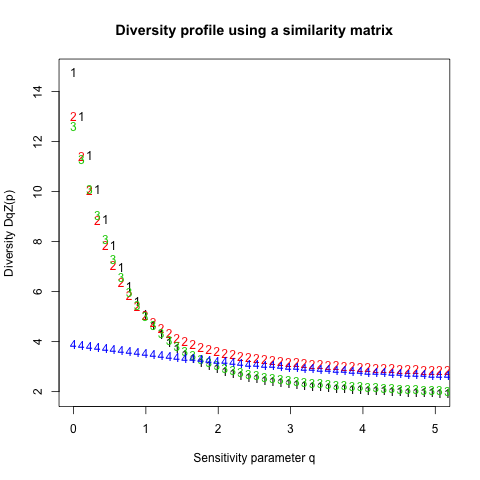

In [91]:
%%R

colnames(Dqz)=colnames(samp)
# Plot the diversity profiles for all the samples on the same graph.
  matplot(qq,Dqz, ylim = c(min(Dqz),max(Dqz)), xlim = c(0,5),
          xlab="Sensitivity parameter q",
          ylab="Diversity DqZ(p)",
          main="Diversity profile using a similarity matrix"
          )
 